In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

#read the file QCES_DIC_DATA.gpkg
qfield_data = gpd.read_file('QCES_DIC_DATA.gpkg')

#read first part of the data 
spec_data = pd.read_csv('Aqueous Data - Summary of Alkalinity_DIC.csv')

#read the second part of the data
spec_data2 = pd.read_csv('Aqueous Data - 2nd Alkalinity and DIC.csv')

#preprocess data from the first dataset, make sure the typo, lowcase/upcase and spacing problem all been solved out 
for sample_id in spec_data['Sample ID (as in QField)']:
    if sample_id not in qfield_data['SampleID'].values:
        print(sample_id)

qfield_data['SampleID'] = qfield_data['SampleID'].str.replace(' ','').str.upper()
spec_data['Sample ID (as in QField)'] = spec_data['Sample ID (as in QField)'].str.replace(' ','').str.upper()
qfield_data.loc[qfield_data.SampleID == 'AOJ3', 'SampleID'] = 'AOJE3'

for sample_id in spec_data['Sample ID (as in QField)']:
    if sample_id not in qfield_data['SampleID'].values:
        print(sample_id)

spec_data['Dataset'] = 'Oct'
spec_data2['Dataset'] = 'Nov'
#now merge the two datasets
merged_data = pd.concat([spec_data, spec_data2], ignore_index=True)
df = pd.DataFrame(merged_data)
file_path = "output_data.csv"
df.to_csv(file_path, index=False)

#create the data we will woking on, call it all_data
all_data = pd.merge(qfield_data, merged_data, left_on = 'SampleID', right_on = 'Sample ID (as in QField)',how = 'outer')
all_data = all_data.drop(columns = ['Alkalinity', 'DIC', 'Sample ID (as in QField)'])

extracted_tds = all_data['Descriptio'].astype(str).str.extract(r'([0-9]{2,3})\s*ppm', expand=False)

# combine the column with the data
all_data['TDS (ppm)'] = all_data['TDS'].combine_first(extracted_tds)

# delate cells
all_data = all_data.drop(columns=['TDS', 'Descriptio','Photo1','Photo2','Photo3','id','Unnamed: 4'])

JAWN 1
JAWN 2
JAWN 3
JAWN 4
JAWN 5
AOJE 3
AOJE 4
AOJE 5
RAJAS2


/Users/star/miniconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'QCES_DIC_DATA.gpkg': 'Data_Collection' (default), 'data_collection_dic'. Specify layer parameter to avoid this warning.
  result = read_func(


In [2]:
all_data.dropna(axis='index', thresh = 3, inplace = True, ignore_index = True)
all_data.drop(all_data.index[all_data['pH']>14], inplace=True)
all_data.drop(all_data.index[all_data['Temp']>100], inplace=True)
all_data.drop(all_data.index[all_data['TDS (ppm)'].astype(float)<20], inplace=True)

In [3]:
if (all_data['Corrected alkalinity (Y/N)'] != 'y').any():
    all_data['Alkalinity (µmol/L)'] = all_data['Alkalinity (µmol/L)'] * 0.059 / 0.05
all_data.head()

,pH,SampleID,Temp,EC,Date,geometry,Group,Alkalinity (µmol/L),CO2 (mg/L),Dataset,Corrected alkalinity (Y/N),TDS (ppm)
0,6.99,AOJE1,NaN,NaN,2024-10-22T11:53:52.314,POINT (14970.098 6830166.545),AOJE,3198.1304,133.0,Oct,NaN,420
1,7.28,AOJE10,11.4,NaN,2024-11-12T11:09:00.721,POINT (15018.776 6830232.744),AOJE,2969.4346,204.3,Nov,y,375.0
3,7.26,AOJE12,11.3,NaN,2024-11-12T11:47:19.647,POINT (14986.462 6830183.113),NaN,NaN,NaN,NaN,NaN,383.0
5,7.27,AOJE13,11.2,NaN,2024-11-12T11:51:30.347,POINT (14968.408 6830194.45),NaN,NaN,NaN,NaN,NaN,381.0
6,7.26,AOJE14,11.2,NaN,2024-11-12T11:53:05.583,POINT (14982.67 6830184.522),NaN,NaN,NaN,NaN,NaN,381.0


In [4]:
#calculating pCO2 by using cbsyst
import cbsyst as cb

#TA = np.linspace(3200, 4400, 100)
#DIC = np.linspace(3000, 6000, 100)
#xTA, yDIC = np.meshgrid(TA, DIC)

#cs = cb.Csys(TA=xTA, DIC=yDIC, S_in=0, T_in=10)

cs_data = cb.Csys(TA=all_data['Alkalinity (µmol/L)'], pHNBS=all_data['pH'], S_in=0, T_in=10)

In [5]:
#update the value in all_data
all_data['pCO2'] = cs_data.pCO2 #400 atmosphere value

In [6]:
import cbsyst as cb
import pandas as pd

# Function to calculate DIC using cbsyst
def calculate_DIC(row):
    # Extract values from the row
    pH = row['pH']
    pCO2 = row['pCO2']
    temperature = row['Temp']
    
    # Use cbsyst to calculate DIC
    results = cb.Csys(
        pCO2=pCO2,
        TA=row["Alkalinity (µmol/L)"],  # Total Alkalinity
        T_in=temperature,
        S_in=0  # Default salinity
    )
    
    # Extract and return DIC
    return float(results["DIC"])

# Filter the data to only include rows where 'Alkalinity (µmol/L)' is not NaN
filtered_data = all_data.dropna(subset=['Alkalinity (µmol/L)'])

# Apply the function to calculate DIC for the filtered data
filtered_data['DIC'] = filtered_data.apply(calculate_DIC, axis=1)

# Merge the calculated DIC back to the original DataFrame
# This will only add DIC values to rows that had non-NaN Alkalinity
all_data = pd.merge(
    all_data,
    filtered_data[['SampleID', 'DIC']],  # Merge on 'SampleID' (or another unique identifier)
    on='SampleID',
    how='left'
)

# Display the updated DataFrame
all_data.head()


/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_84538/3294773093.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(results["DIC"])
/Users/star/miniconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,pH,SampleID,Temp,EC,Date,geometry,Group,Alkalinity (µmol/L),CO2 (mg/L),Dataset,Corrected alkalinity (Y/N),TDS (ppm),pCO2,DIC
0,6.99,AOJE1,NaN,NaN,2024-10-22T11:53:52.314,POINT (14970.098 6830166.545),AOJE,3198.1304,133.0,Oct,NaN,420,15342.483757,NaN
1,7.28,AOJE10,11.4,NaN,2024-11-12T11:09:00.721,POINT (15018.776 6830232.744),AOJE,2969.4346,204.3,Nov,y,375.0,7286.332250,3332.458538
2,7.26,AOJE12,11.3,NaN,2024-11-12T11:47:19.647,POINT (14986.462 6830183.113),NaN,NaN,NaN,NaN,NaN,383.0,NaN,NaN
3,7.27,AOJE13,11.2,NaN,2024-11-12T11:51:30.347,POINT (14968.408 6830194.45),NaN,NaN,NaN,NaN,NaN,381.0,NaN,NaN
4,7.26,AOJE14,11.2,NaN,2024-11-12T11:53:05.583,POINT (14982.67 6830184.522),NaN,NaN,NaN,NaN,NaN,381.0,NaN,NaN


In [7]:
all_data['Region'] = 'Region1'  
all_data.loc[all_data['geometry'].x > 15062, 'Region'] = 1
all_data.loc[(all_data['geometry'].y > 6830203.2) & (all_data['geometry'].x <= 15062) & (all_data['geometry'].x > 14959.7) , 'Region'] = 2
all_data.loc[all_data['geometry'].y <= 6830203.2, 'Region'] = 3
all_data.loc[(all_data['geometry'].x <= 14959.7) & (all_data['geometry'].y > 6830203.2),  'Region'] = 4

In [8]:
all_data.head()

,pH,SampleID,Temp,EC,Date,geometry,Group,Alkalinity (µmol/L),CO2 (mg/L),Dataset,Corrected alkalinity (Y/N),TDS (ppm),pCO2,DIC,Region
0,6.99,AOJE1,NaN,NaN,2024-10-22T11:53:52.314,POINT (14970.098 6830166.545),AOJE,3198.1304,133.0,Oct,NaN,420,15342.483757,NaN,3
1,7.28,AOJE10,11.4,NaN,2024-11-12T11:09:00.721,POINT (15018.776 6830232.744),AOJE,2969.4346,204.3,Nov,y,375.0,7286.332250,3332.458538,2
2,7.26,AOJE12,11.3,NaN,2024-11-12T11:47:19.647,POINT (14986.462 6830183.113),NaN,NaN,NaN,NaN,NaN,383.0,NaN,NaN,3
3,7.27,AOJE13,11.2,NaN,2024-11-12T11:51:30.347,POINT (14968.408 6830194.45),NaN,NaN,NaN,NaN,NaN,381.0,NaN,NaN,3
4,7.26,AOJE14,11.2,NaN,2024-11-12T11:53:05.583,POINT (14982.67 6830184.522),NaN,NaN,NaN,NaN,NaN,381.0,NaN,NaN,3


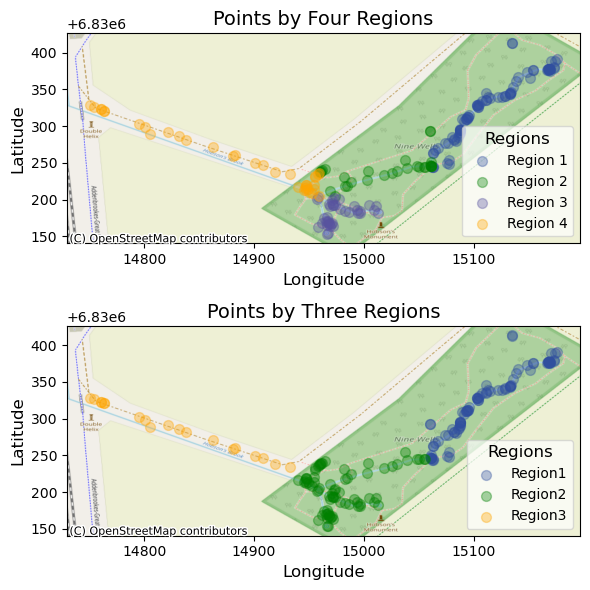

In [9]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl
import contextily as ctx

# Assuming all_data is a GeoDataFrame with 'geometry', 'region', and other relevant columns

# Create the figure and axis
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

all_data['Region'] = 'Region1'  # 默认区域
all_data.loc[all_data['geometry'].x > 15062, 'Region'] = 1
all_data.loc[(all_data['geometry'].y > 6830203.2) & (all_data['geometry'].x <= 15062) & (all_data['geometry'].x > 14959.7) , 'Region'] = 2
all_data.loc[all_data['geometry'].y <= 6830203.2, 'Region'] = 3
all_data.loc[(all_data['geometry'].x <= 14959.7) & (all_data['geometry'].y > 6830203.2),  'Region'] = 4
# Define the shapes and discrete colors for each region
region_shapes = {
    '1': 'o',  # Circle
    '2': 'o',  # Triangle
    '3': 'o',  # Star
    '4': 'o',  # Square
}

region_colors = {
    '1': '#304f9e',
    '2': 'green',
    '3': '#58539f',
    '4': 'orange',
}
alpha = 0.35

# Plot on the first subplot
for region, shape in region_shapes.items():
    region_data = all_data[all_data['Region'] == int(region)]
    ax[0].scatter(
        region_data.geometry.x, region_data.geometry.y,
        color=region_colors[region],  # Use discrete color
        alpha=alpha,
        # edgecolor='k',  # Add border
        marker=shape,  # Set marker shape
        s=50,  # Marker size
        label=f'Region {region}'  # Legend label
    )

# Add basemap to the first subplot
ctx.add_basemap(ax[0], source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend to the first subplot
ax[0].legend(title='Regions',
    fontsize=10,
    title_fontsize=12,
    loc='lower right',  
    frameon=True,       
    framealpha=0.7)

# Set title and labels for the first subplot
ax[0].set_title('Points by Four Regions', fontsize=14)
ax[0].set_xlabel('Longitude', fontsize=12)
ax[0].set_ylabel('Latitude', fontsize=12)

# Manually classify regions for the second subplot
all_data['Region'] = 'Region1'  # Default region
all_data.loc[all_data['geometry'].x < 14935, 'Region'] = 'Region3'
all_data.loc[(all_data['geometry'].x >= 14935) & (all_data['geometry'].x < 15060), 'Region'] = 'Region2'
all_data.loc[all_data['geometry'].x >= 15060, 'Region'] = 'Region1'

region_shapes = {
    'Region1': 'o',  # Circle
    'Region2': 'o',  # Triangle
    'Region3': 'o',  # Square
}

region_colors = {
    'Region1': '#304f9e',
    'Region2': 'green',
    'Region3': 'orange',
}
alpha = 0.35

# Plot on the second subplot
for region, shape in region_shapes.items():
    region_data = all_data[all_data['Region'] == region]
    ax[1].scatter(
        region_data.geometry.x, region_data.geometry.y,
        color=region_colors[region],  # Use discrete color
        alpha=alpha,
        # edgecolor='k',  # Add border
        marker=shape,  # Set marker shape
        s=50,  # Marker size
        label=f'{region}'  # Legend label
    )

# Add basemap to the second subplot
ctx.add_basemap(ax[1], source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend to the second subplot
ax[1].legend(title='Regions',
    fontsize=10,
    title_fontsize=12,
    loc='lower right',  # 固定位置在右上角
    frameon=True,       # 显示图例框
    framealpha=0.7)

# Set title and labels for the second subplot
ax[1].set_title('Points by Three Regions', fontsize=14)
ax[1].set_xlabel('Longitude', fontsize=12)
ax[1].set_ylabel('Latitude', fontsize=12)

# Beautify layout
plt.tight_layout()
plt.savefig('Region_Plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
oct_data = pd.read_csv('Oct_data.csv')

#read the second part of the data
nov_data = pd.read_csv('Nov_data.csv')


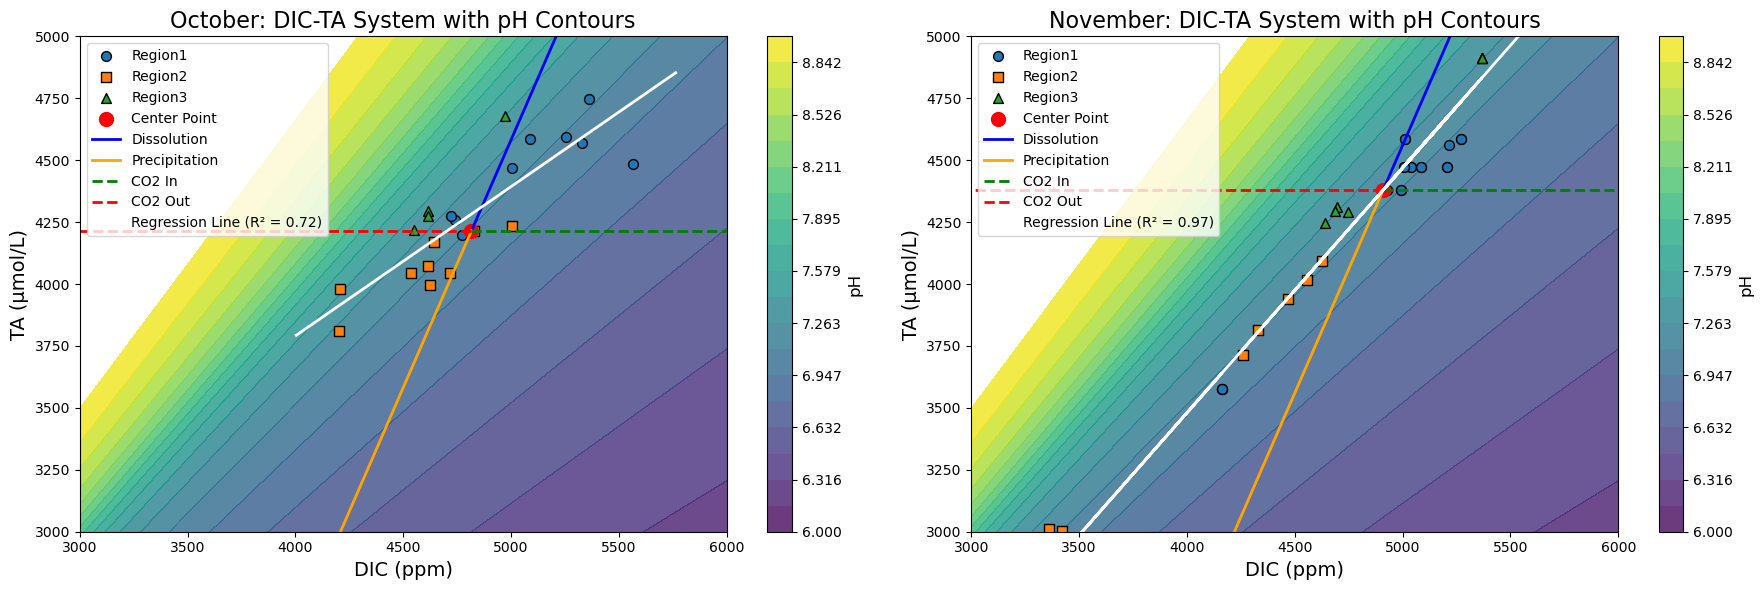

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import cbsyst as cb

# Define the TA and DIC ranges
TA = np.linspace(2000, 5000, 200)
DIC = np.linspace(2000, 6500, 200)
xTA, yDIC = np.meshgrid(TA, DIC)

# Calculate the carbonate system for the grid
cs = cb.Csys(TA=xTA, DIC=yDIC, S_in=0, T_in=10)

# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# October Data (First subplot)
pH_values = cs.pHtot
contour_levels = np.linspace(6, 9, 20)

# Contour plot
contourf = ax[0].contourf(cs.DIC, cs.TA, pH_values, levels=contour_levels, cmap='viridis', alpha=0.8)
cbar = plt.colorbar(contourf, ax=ax[0])
cbar.set_label('pH', fontsize=12)

# Scatter plot by region
region_shapes = {
    'Region1': 'o',
    'Region2': 's',
    'Region3': '^',
}

for region, shape in region_shapes.items():
    region_data = oct_data[oct_data['Region'] == region]
    ax[0].scatter(
        region_data['DIC'], region_data['Alkalinity (µmol/L)'],
        label=region, marker=shape, s=50, edgecolor='k'
    )

# Center point
center_DIC = oct_data['DIC'].mean()
center_TA = np.nanmean(oct_data['Alkalinity (µmol/L)'])
ax[0].scatter(center_DIC, center_TA, color='red', label='Center Point', s=100)

# Dissolution and precipitation vectors
dDIC = 2000
stoic_calc = 2
ax[0].plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_calc],
           label='Dissolution', color='blue', linewidth=2)
ax[0].plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_calc],
           label='Precipitation', color='orange', linewidth=2)

# CO2 vectors
ax[0].plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA], label='CO2 In',
           color='green', linestyle='--', linewidth=2)
ax[0].plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA], label='CO2 Out',
           color='red', linestyle='--', linewidth=2)

# Add regression line for October data
oct_valid_data = oct_data.dropna(subset=['DIC', 'Alkalinity (µmol/L)'])  # Drop rows with NaN in either column
X_oct = oct_valid_data['DIC'].values.reshape(-1, 1)
Y_oct = oct_valid_data['Alkalinity (µmol/L)'].values


# October regression line extension
if len(X_oct) > 0 and len(Y_oct) > 0:
    reg_oct = LinearRegression()
    reg_oct.fit(X_oct, Y_oct)
    
    # Extend the range of X for plotting
    X_oct_extended = np.linspace(X_oct.min() - 200, X_oct.max() + 200, 500).reshape(-1, 1)
    Y_pred_oct = reg_oct.predict(X_oct_extended)
    
    # Plot the extended regression line
    ax[0].plot(X_oct_extended, Y_pred_oct, color='white', linewidth=2, label=f'Regression Line (R² = {reg_oct.score(X_oct, Y_oct):.2f})')

# Customize October subplot
ax[0].set_xlim(3000, 6000)
ax[0].set_ylim(3000, 5000)
ax[0].set_xlabel('DIC (ppm)', fontsize=14)
ax[0].set_ylabel('TA (µmol/L)', fontsize=14)
ax[0].set_title('October: DIC-TA System with pH Contours', fontsize=16)
ax[0].legend(fontsize=10, loc='upper left', frameon=True)

# November Data (Second subplot)
contourf = ax[1].contourf(cs.DIC, cs.TA, pH_values, levels=contour_levels, cmap='viridis', alpha=0.8)
cbar = plt.colorbar(contourf, ax=ax[1])
cbar.set_label('pH', fontsize=12)

for region, shape in region_shapes.items():
    region_data = nov_data[nov_data['Region'] == region]
    ax[1].scatter(
        region_data['DIC'], region_data['Alkalinity (µmol/L)'],
        label=region, marker=shape, s=50, edgecolor='k'
    )

# Center point
center_DIC = nov_data['DIC'].mean()
center_TA = np.nanmean(nov_data['Alkalinity (µmol/L)'])
ax[1].scatter(center_DIC, center_TA, color='red', label='Center Point', s=100)

# Dissolution and precipitation vectors
ax[1].plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_calc],
           label='Dissolution', color='blue', linewidth=2)
ax[1].plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_calc],
           label='Precipitation', color='orange', linewidth=2)

# CO2 vectors
ax[1].plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA], label='CO2 In',
           color='green', linestyle='--', linewidth=2)
ax[1].plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA], label='CO2 Out',
           color='red', linestyle='--', linewidth=2)

# Add regression line for November data
nov_valid_data = nov_data.dropna(subset=['DIC', 'Alkalinity (µmol/L)'])  # Drop rows with NaN in either column
X_nov = nov_valid_data['DIC'].values.reshape(-1, 1)
Y_nov = nov_valid_data['Alkalinity (µmol/L)'].values

if len(X_nov) > 0 and len(Y_nov) > 0:
    reg_nov = LinearRegression()
    reg_nov.fit(X_nov, Y_nov)
    Y_pred_nov = reg_nov.predict(X_nov)
    ax[1].plot(
        X_nov, Y_pred_nov, color='white', linewidth=2,
        label=f'Regression Line (R² = {reg_nov.score(X_nov, Y_nov):.2f})'
    )

# Customize November subplot
ax[1].set_xlim(3000, 6000)
ax[1].set_ylim(3000, 5000)
ax[1].set_xlabel('DIC (ppm)', fontsize=14)
ax[1].set_ylabel('TA (µmol/L)', fontsize=14)
ax[1].set_title('November: DIC-TA System with pH Contours', fontsize=16)
ax[1].legend(fontsize=10, loc='upper left', frameon=True)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('Oct-Nov_DIC-TA_with_Regression', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x600 with 0 Axes>

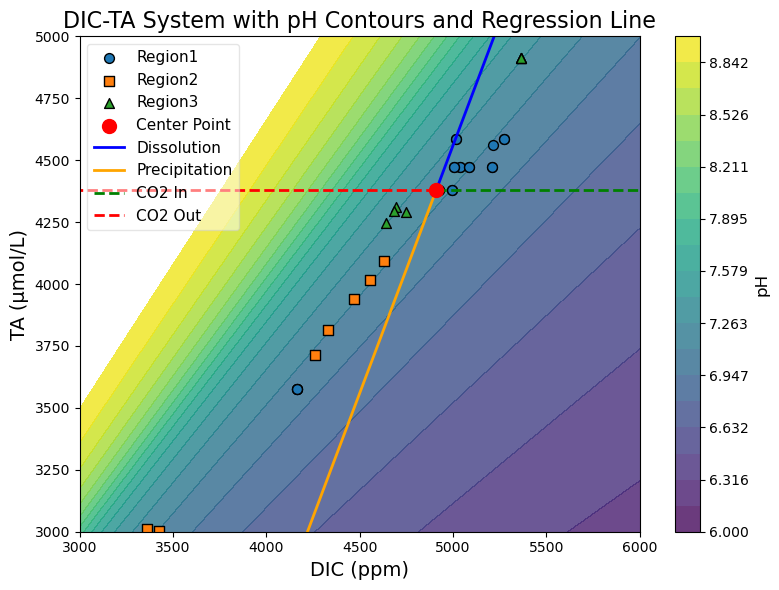

In [12]:
# Set extended ranges for DIC and TA
TA = np.linspace(2000, 5000, 200)  # Extend the range for TA
DIC = np.linspace(2000, 6500, 200)  # Extend the range for DIC
xTA, yDIC = np.meshgrid(TA, DIC)

# Calculate the carbon system
cs = cb.Csys(TA=xTA, DIC=yDIC, S_in=0, T_in=10)
cs_data = cb.Csys(TA=nov_data['Alkalinity (µmol/L)'], pHNBS=nov_data['pH'], S_in=0, T_in=10)

# Calculate the center point
center_DIC = nov_data.DIC.mean()
center_TA = np.nanmean(nov_data['Alkalinity (µmol/L)'])

# Create the canvas
plt.figure(figsize=(8, 6))  # Set a larger figure size

# Use pHtot data
pH_values = cs.pHtot  # Or try using cs.pHNBS
contour_levels = np.linspace(6, 9, 20)  # Set contour levels for pH

# Plot the filled contour (color regions) for DIC-TA using pH values
plt.figure(figsize=(8, 6))
contourf = plt.contourf(cs.DIC, cs.TA, pH_values, levels=contour_levels, cmap='viridis', alpha=0.8)
cbar = plt.colorbar(contourf)
cbar.set_label('pH', fontsize=12)

# Plot scatter points grouped by the Region column
region_shapes = {
    'Region1': 'o',  # Replace with actual Region names
    'Region2': 's',
    'Region3': '^',
}

for region, shape in region_shapes.items():
    region_data = nov_data[nov_data['Region'] == region]
    plt.scatter(
        region_data['DIC'], region_data['Alkalinity (µmol/L)'],
        label=region,
        marker=shape,
        s=50,
        edgecolor='k'
    )

# Mark the center point
plt.scatter(center_DIC, center_TA, color='red', zorder=999, label='Center Point', s=100)

# Vectors for dissolution and precipitation
dDIC = 2000
stoic_calc = 2
stoic_resp = 0

# Use the center point as the starting point
plt.plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_calc], label='Dissolution', color='blue', linewidth=2)
plt.plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_calc], label='Precipitation', color='orange', linewidth=2)

# Vectors for CO2 in and CO2 out
plt.plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_resp], label='CO2 In', color='green', linestyle='--', linewidth=2)
plt.plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_resp], label='CO2 Out', color='red', linestyle='--', linewidth=2)

# Add regression line
# Prepare regression data
#X = nov_data['DIC'].values.reshape(-1, 1)  # Independent variable
#Y = nov_data['Alkalinity (µmol/L)'].values  # Dependent variable

# Perform linear regression
#from sklearn.linear_model import LinearRegression
#reg = LinearRegression()
#reg.fit(X, Y)
#Y_pred = reg.predict(X)

# Plot the regression line
#plt.plot(nov_data['DIC'], Y_pred, color='white', linewidth=2, label=f'Regression Line (R² = {reg.score(X, Y):.2f})')

# Set the legend
plt.legend(fontsize=11, loc='upper left', frameon=True, framealpha=0.5)

# Set the axis range
plt.xlim(3000, 6000)
plt.ylim(3000, 5000)

# Set labels
plt.xlabel('DIC (ppm)', fontsize=14)
plt.ylabel('TA (µmol/L)', fontsize=14)

# Beautify the chart
plt.title('DIC-TA System with pH Contours and Regression Line', fontsize=16)

# Display the chart
plt.tight_layout()
plt.show()

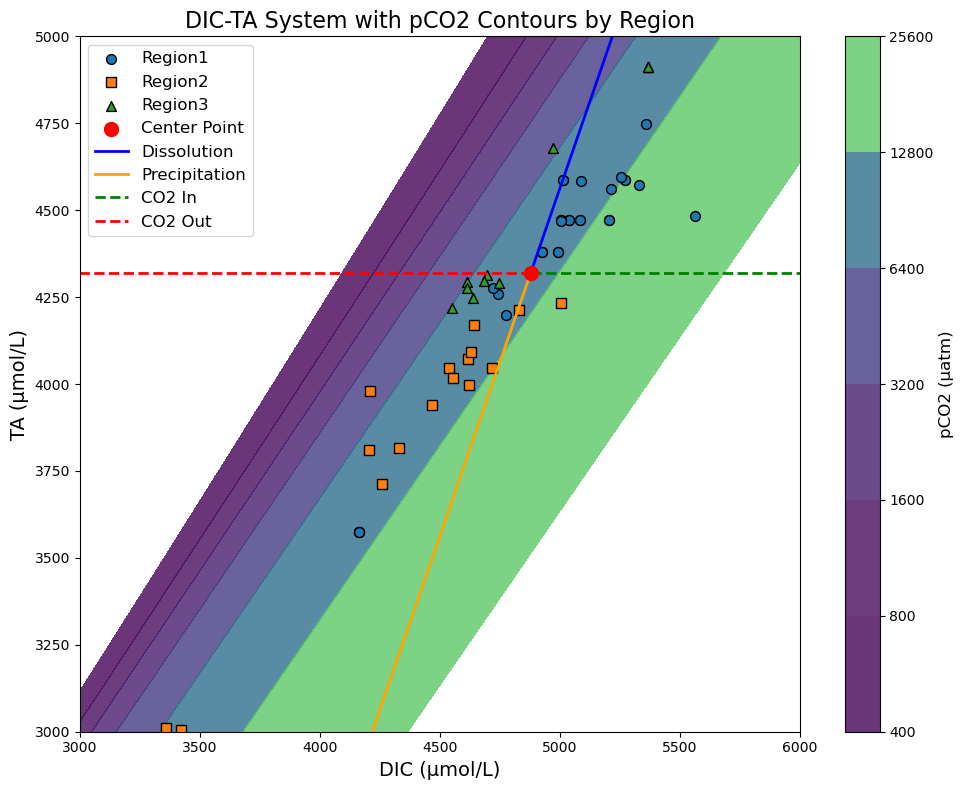

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cbsyst as cb

# Set extended ranges for DIC and TA
TA = np.linspace(2000, 5000, 200)  # Extend the range for TA
DIC = np.linspace(2000, 6500, 200)  # Extend the range for DIC
xTA, yDIC = np.meshgrid(TA, DIC)

# Calculate the carbon system
cs = cb.Csys(TA=xTA, DIC=yDIC, S_in=0, T_in=10)
cs_data = cb.Csys(TA=all_data['Alkalinity (µmol/L)'], pHNBS=all_data['pH'], S_in=0, T_in=10)

# Calculate the center point
center_DIC = all_data.DIC.mean()
center_TA = np.nanmean(all_data['Alkalinity (µmol/L)'])

# Create the canvas
plt.figure(figsize=(10, 8))  # Set a larger figure size

# Plot the filled contour (color regions) for DIC-TA
contour_levels = [400, 800, 1600, 3200, 6400, 12800, 25600]
contourf = plt.contourf(cs.DIC, cs.TA, cs.pCO2, levels=contour_levels, cmap='viridis', alpha=0.8)  # Use gradient colors
cbar = plt.colorbar(contourf)
cbar.set_label('pCO2 (µatm)', fontsize=12)

# Plot scatter points grouped by the Region column
region_shapes = {
    'Region1': 'o',  # Circle
    'Region2': 's',  # Square
    'Region3': '^',  # Triangle
}

for region, shape in region_shapes.items():
    region_data = all_data[all_data['Region'] == region]
    plt.scatter(
        region_data['DIC'], region_data['Alkalinity (µmol/L)'],
        label=region,
        marker=shape,
        s=50,
        edgecolor='k'
    )

# Mark the center point
plt.scatter(center_DIC, center_TA, color='red', zorder=999, label='Center Point', s=100)

# Vectors for dissolution and precipitation
dDIC = 2000
stoic_calc = 2
stoic_resp = 0

# Use the center point as the starting point
plt.plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_calc], label='Dissolution', color='blue', linewidth=2)
plt.plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_calc], label='Precipitation', color='orange', linewidth=2)

# Vectors for CO2 in and CO2 out
plt.plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_resp], label='CO2 In', color='green', linestyle='--', linewidth=2)
plt.plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_resp], label='CO2 Out', color='red', linestyle='--', linewidth=2)

# Set the legend
plt.legend(fontsize=12, loc='upper left', frameon=True)

# Set axis limits
plt.xlim(3000, 6000)
plt.ylim(3000, 5000)

# Set labels
plt.xlabel('DIC (µmol/L)', fontsize=14)
plt.ylabel('TA (µmol/L)', fontsize=14)

# Beautify the chart
plt.title('DIC-TA System with pCO2 Contours by Region', fontsize=16)

# Display the chart
plt.tight_layout()
plt.show()

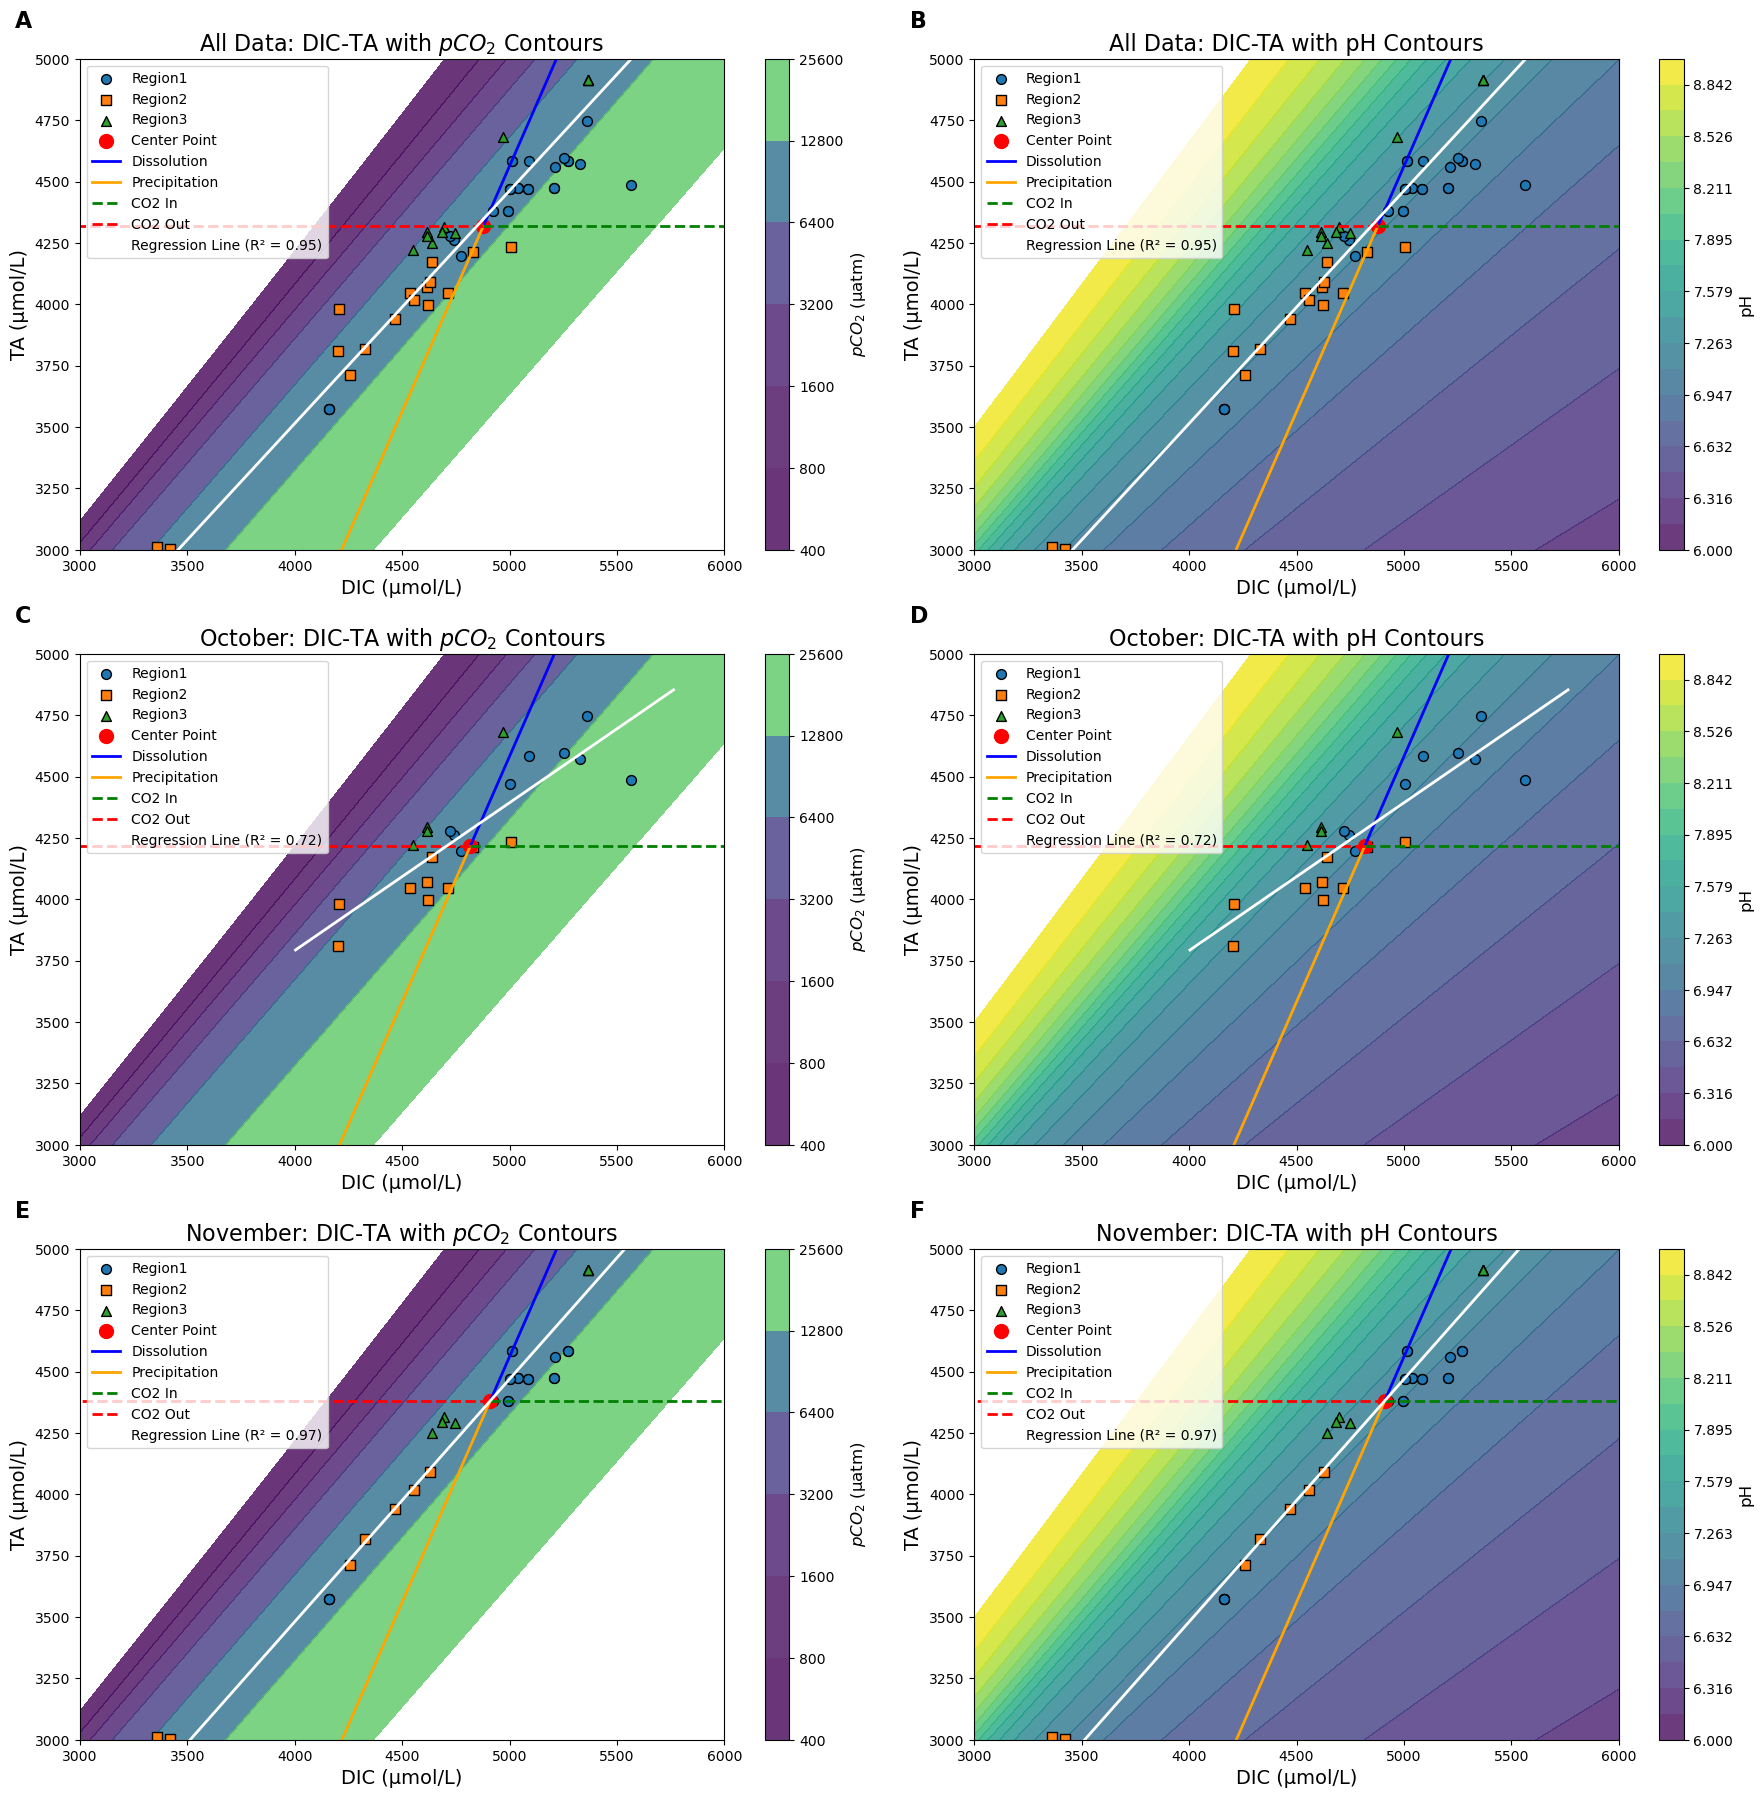

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import cbsyst as cb

# Define the TA and DIC ranges
TA = np.linspace(2000, 5000, 200)
DIC = np.linspace(2000, 6500, 200)
xTA, yDIC = np.meshgrid(TA, DIC)

# Define function to calculate regression line
def add_regression(ax, data, label):
    valid_data = data.dropna(subset=['DIC', 'Alkalinity (µmol/L)'])
    X = valid_data['DIC'].values.reshape(-1, 1)
    Y = valid_data['Alkalinity (µmol/L)'].values
    if len(X) > 0 and len(Y) > 0:
        reg = LinearRegression()
        reg.fit(X, Y)
        X_extended = np.linspace(X.min() - 200, X.max() + 200, 500).reshape(-1, 1)
        Y_pred = reg.predict(X_extended)
        ax.plot(X_extended, Y_pred, color='white', linewidth=2, label=f'{label} (R² = {reg.score(X, Y):.2f})')

# Set up subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Data to be plotted
datasets = [(all_data, "All Data"), (oct_data, "October"), (nov_data, "November")]
labels = ["$pCO_2$", "pH"]
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F']

dDIC = 2000
stoic_calc = 2
for idx, (data, dataset_label) in enumerate(datasets):
    # Calculate carbonate system for the dataset
    cs = cb.Csys(TA=xTA, DIC=yDIC, S_in=0, T_in=10)

    # pCO2 contour plot
    contour_levels = [400, 800, 1600, 3200, 6400, 12800, 25600]
    contourf = axes[idx, 0].contourf(cs.DIC, cs.TA, cs.pCO2, levels=contour_levels, cmap='viridis', alpha=0.8)
    cbar = plt.colorbar(contourf, ax=axes[idx, 0])
    cbar.set_label('$pCO_2$ (µatm)', fontsize=12)
    
    # Scatter points by region
    region_shapes = {'Region1': 'o', 'Region2': 's', 'Region3': '^'}
    for region, shape in region_shapes.items():
        region_data = data[data['Region'] == region]
        axes[idx, 0].scatter(
            region_data['DIC'], region_data['Alkalinity (µmol/L)'],
            label=region, marker=shape, s=50, edgecolor='k'
        )

    # Center point
    center_DIC = data['DIC'].mean()
    center_TA = np.nanmean(data['Alkalinity (µmol/L)'])
    axes[idx, 0].scatter(center_DIC, center_TA, color='red', label='Center Point', s=100)

    # Dissolution and precipitation vectors
    axes[idx, 0].plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_calc],
                    label='Dissolution', color='blue', linewidth=2)
    axes[idx, 0].plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_calc],
                    label='Precipitation', color='orange', linewidth=2)

    # CO2 vectors
    axes[idx, 0].plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA], label='CO2 In',
                    color='green', linestyle='--', linewidth=2)
    axes[idx, 0].plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA], label='CO2 Out',
                    color='red', linestyle='--', linewidth=2)

    add_regression(axes[idx, 0], data, "Regression Line")

    axes[idx, 0].set_xlim(3000, 6000)
    axes[idx, 0].set_ylim(3000, 5000)
    axes[idx, 0].set_xlabel('DIC (µmol/L)', fontsize=14)
    axes[idx, 0].set_ylabel('TA (µmol/L)', fontsize=14)
    axes[idx, 0].set_title(f'{dataset_label}: DIC-TA with $pCO_2$ Contours', fontsize=16)
    axes[idx, 0].legend(fontsize=10, loc='upper left')

    # Add subplot label
    axes[idx, 0].text(-0.1, 1.1, subplot_labels[idx * 2], transform=axes[idx, 0].transAxes,
                      fontsize=16, fontweight='bold', va='top', ha='left')

    # pH contour plot
    contourf = axes[idx, 1].contourf(cs.DIC, cs.TA, cs.pHtot, levels=np.linspace(6, 9, 20), cmap='viridis', alpha=0.8)
    cbar = plt.colorbar(contourf, ax=axes[idx, 1])
    cbar.set_label('pH', fontsize=12)

    for region, shape in region_shapes.items():
        region_data = data[data['Region'] == region]
        axes[idx, 1].scatter(
            region_data['DIC'], region_data['Alkalinity (µmol/L)'],
            label=region, marker=shape, s=50, edgecolor='k'
        )

    # Center point
    axes[idx, 1].scatter(center_DIC, center_TA, color='red', label='Center Point', s=100)

    # Dissolution and precipitation vectors
    axes[idx, 1].plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_calc],
                    label='Dissolution', color='blue', linewidth=2)
    axes[idx, 1].plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_calc],
                    label='Precipitation', color='orange', linewidth=2)

    # CO2 vectors
    axes[idx, 1].plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA], label='CO2 In',
                    color='green', linestyle='--', linewidth=2)
    axes[idx, 1].plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA], label='CO2 Out',
                    color='red', linestyle='--', linewidth=2)

    add_regression(axes[idx, 1], data, "Regression Line")

    axes[idx, 1].set_xlim(3000, 6000)
    axes[idx, 1].set_ylim(3000, 5000)
    axes[idx, 1].set_xlabel('DIC (µmol/L)', fontsize=14)
    axes[idx, 1].set_ylabel('TA (µmol/L)', fontsize=14)
    axes[idx, 1].set_title(f'{dataset_label}: DIC-TA with pH Contours', fontsize=16)
    axes[idx, 1].legend(fontsize=10, loc='upper left')

    # Add subplot label
    axes[idx, 1].text(-0.1, 1.1, subplot_labels[idx * 2 + 1], transform=axes[idx, 1].transAxes,
                      fontsize=16, fontweight='bold', va='top', ha='left')

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('DIC_TA_pCO2_pH_Contours.png', dpi=300, bbox_inches='tight')
plt.show()